<a href="https://colab.research.google.com/github/min02yam/R-study/blob/main/20220508_iris_%EB%8B%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Data analysis & Evaluation


## 3-1. iris 데이터셋에서 Species rpart, svm예측 모형을 만든 후 높은 Accuracy값을 가지는 모델의 예측값을 csv 파일로 제출하시오.

## 3-2. 그 모델의 ROC곡선을 그리고, AUC값도 구하시오.

> 1. SVM 정리: [링크 텍스트](https://) 
- e1071:: svm, tune.svm  #SVM
- kernlab:: ksvm, #SVM 피처 선택
- (+ caret:: rfeControl #교차 검증)


> 2. 디시전트리 정리: [노션에 정리_하는 중](https://sapphire-sumac-7af.notion.site/b6c10c54c1d04a5096c6644a07f2240f)


> 3. predict에러 https://stackoverflow.com/questions/23085096/type-parameter-of-the-predict-function
> 4. ~~roc에러 
Error: ‘list’ object cannot be coerced to type ‘double’
https://finnstats.com/index.php/2022/02/01/error-list-object-cannot-be-coerced-to-type-double/
멀티클래스에 뉴메릭 못씀~~
~~as.numeric(unlist(List))~~

> 5. multi-label 분류 성능지표
- Balanced data ➡️ Accuracy
- Imbalanced ➡️ f1-score(Recall과 Precisiond의 매크로 애버리지를 이용한 이용한 Harmonic mean, 큰 값에 패널티) 
  - precision= TP/(TP+FP) y , recall= TP/ (TP+FN) x
  * ref1. https://nittaku.tistory.com/295
  * ref2. https://www.youtube.com/watch?v=8DbC39cvvis
  * ref3. https://github.com/woosa7/R_DataAnalytics/blob/master/R_DataMining/Lec/2016_2_DM_MBA_07.pdf


In [1]:
install.packages(c("e1071","kernlab","caret"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘progressr’, ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘iterators’, ‘Rcpp’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘proxy’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’




In [4]:
install.packages(c("rpart", "partykit"))
#install.packages("rpart.plot")

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
library(e1071); library(kernlab) #SVM
library(rpart) # 분류 앤 회귀 트리 cart
library(partykit) # 트리 출력
#library(rpart.plot) # 트리 출력
library(caret) # 하이퍼파라미터 튜닝

Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:kernlab’:

    alpha


Loading required package: lattice

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


In [6]:
#rm(list=ls())
str(iris)

'data.frame':	150 obs. of  5 variables:
 $ Sepal.Length: num  5.1 4.9 4.7 4.6 5 5.4 4.6 5 4.4 4.9 ...
 $ Sepal.Width : num  3.5 3 3.2 3.1 3.6 3.9 3.4 3.4 2.9 3.1 ...
 $ Petal.Length: num  1.4 1.4 1.3 1.5 1.4 1.7 1.4 1.5 1.4 1.5 ...
 $ Petal.Width : num  0.2 0.2 0.2 0.2 0.2 0.4 0.3 0.2 0.2 0.1 ...
 $ Species     : Factor w/ 3 levels "setosa","versicolor",..: 1 1 1 1 1 1 1 1 1 1 ...


In [7]:
#클래스 밸런스 확인
prop.table(table(iris[,5]))


    setosa versicolor  virginica 
 0.3333333  0.3333333  0.3333333 

** 매우 균등함 -> 평가지표는 Acc

In [8]:
#시드설정 및 데이터 분할
set.seed(2022)
inx<-sample(1:nrow(iris), nrow(iris)*0.7, replace=FALSE)
train<-iris[inx,]
test<-iris[-inx,]

### STEP1. SVM- e1071 패키지이용 모델링

In [9]:
#e1071
esvm<-tune.svm(Species~., data=train, gamma=10^(-6:-1), cost=10^(-2:2))$best.model 

-  `HMH기울기(gamma)` 0.01 
- `비용값(cost)` 10
- `best performance` 0.01~대로 계속 나옴.

In [10]:
#summary( tune.svm(Species~., data=train, gamma=2^(-2:1), cost=2^(2:4)) )  # best performance: 0.02 

### STEP2. SVM- kernlab+caret 패키지 이용 모델링

In [11]:
ksvm(Species~., data= train, kernel="rbfdot") # 디폴트 가우시안 래디컬 0.009524 
# ksvm(Species~., data= train, kernel="vanilladot") # 성능비슷함

Support Vector Machine object of class "ksvm" 

SV type: C-svc  (classification) 
 parameter : cost C = 1 

Gaussian Radial Basis kernel function. 
 Hyperparameter : sigma =  0.917538361866533 

Number of Support Vectors : 50 

Objective Function Value : -4.553 -5.078 -14.5891 
Training error : 0.009524 

In [12]:
c(10^(-1:1),5)

[1]  0.1  1.0 10.0  5.0

- 파라미터 튜닝

In [13]:
cost<-c(10^(-1:1),5)

acc<-sapply(cost, function(x){ 
  set.seed(2022)
fit<-ksvm(Species~. , train, kernel="rbfdot", C=x)    
  pred<-predict(fit, test)
  agr<-ifelse(pred==test[,5], 1, 0)
  acc<-sum(agr)/nrow(test)
  
  return(acc)
})

In [14]:
install.packages("ROCR"); library(ROCR)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘gplots’




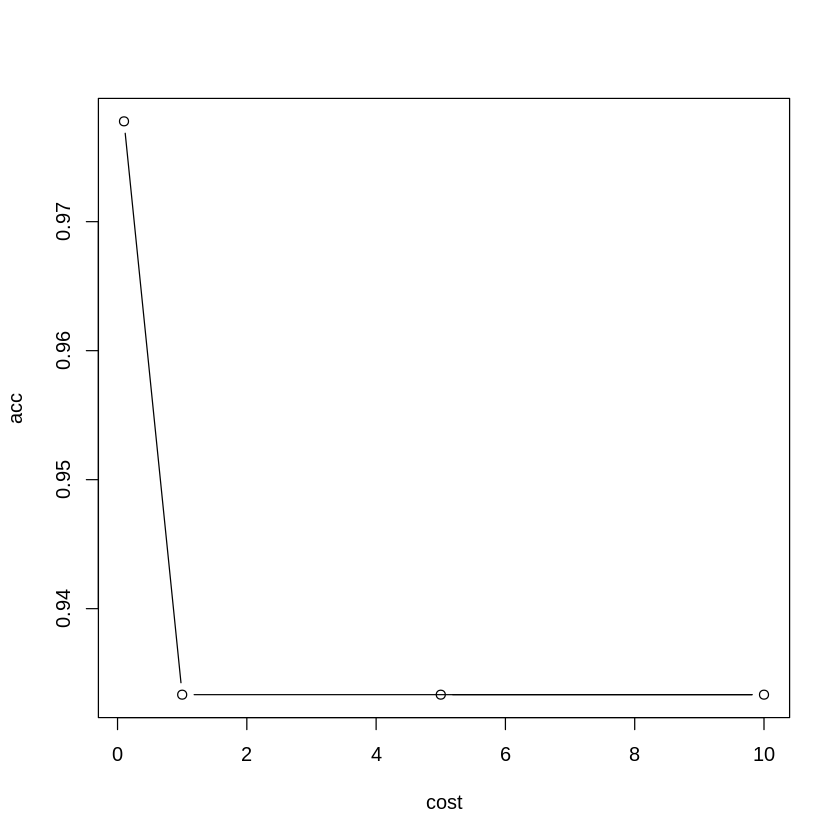

In [15]:
plot(cost, acc, type="b")

- 코스트 범위 다시 줘보기

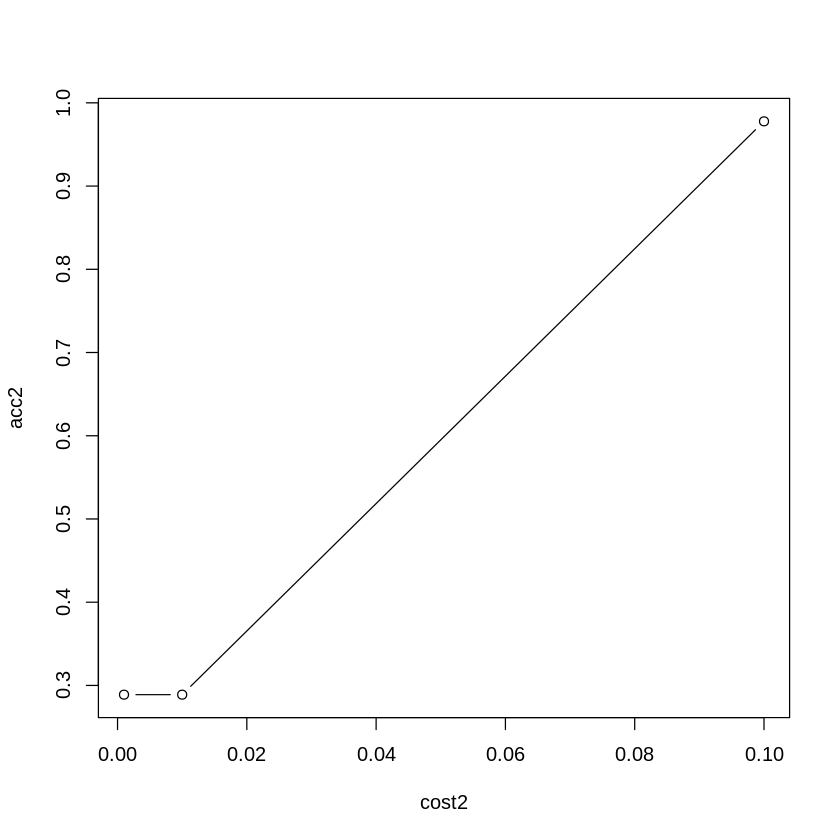

In [16]:
cost2<-c(10^(-3:-1))

acc2<-sapply(cost2, function(x){ 
  set.seed(2022)
fit<-ksvm(Species~. , train, kernel="rbfdot", C=x)    
  pred<-predict(fit, test)
  agr<-ifelse(pred==test[,5], 1, 0)
  acc2<-sum(agr)/nrow(test)
  
  return(acc2)
})

plot(cost2, acc2, type="b")

** `비용값(cost)` 0.1이 제일 좋고, 앞서 시행했던 기본파라미터 C=1은 성능 비교적 별로임

In [17]:
ksvm<-ksvm(Species~., data= train, kernel="rbfdot", C=0.1 ) #파라미터 수정

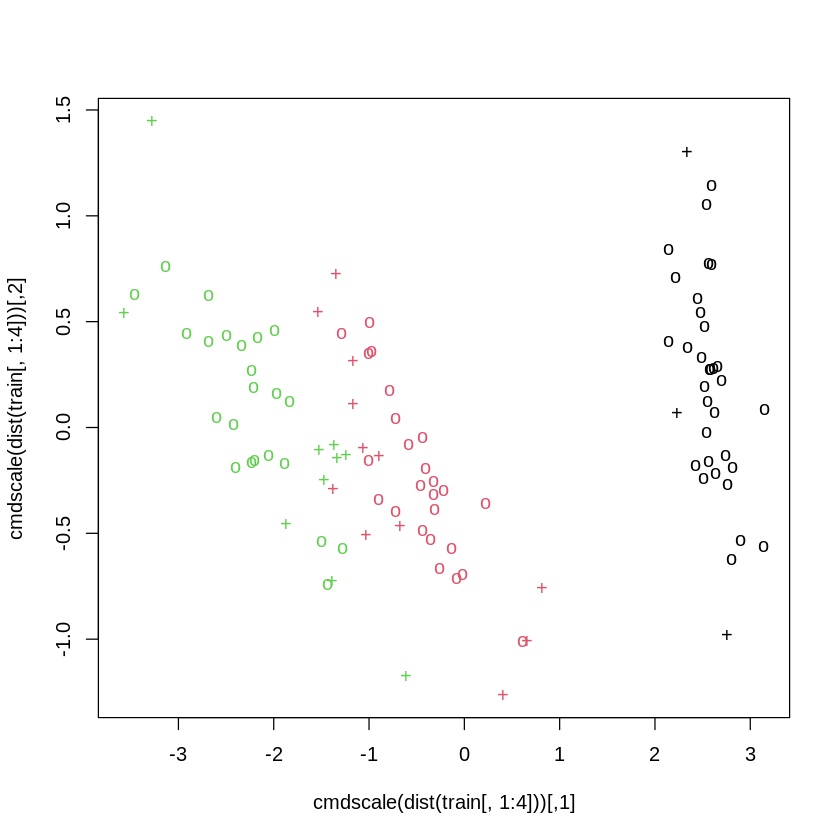

In [18]:
#시각화
plot(cmdscale(dist(train[,1:4])), col=train$Species, pch=c("o","+")[1:nrow(train) %in% esvm$index+1])

** +는 서포트 벡터

In [19]:
#str(esvm) #  $ index          : int [1:25] 1 10 46 62 64 72 74 76 83 84 ...
#esvm$index+1
#?cmdscale

In [20]:
#str(ksvm)
#ksvm

### STEP3. 디시전트리- rpart+partykit 패키지 이용 모델링
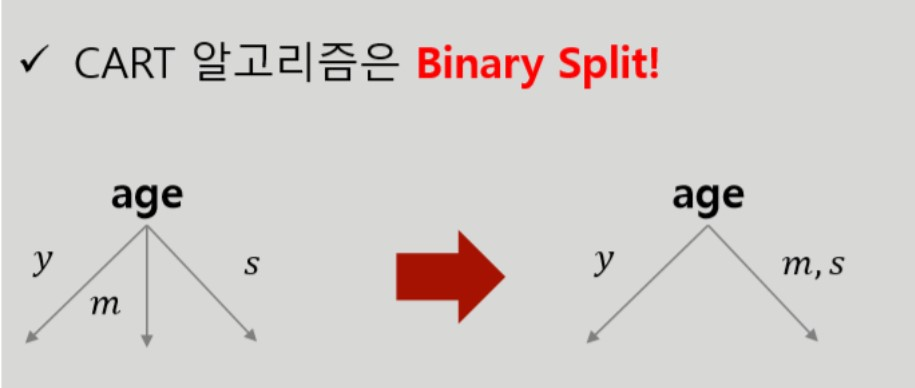
- ref. [이미지 레퍼런스](https://leedakyeong.tistory.com/entry/%EC%9D%98%EC%82%AC%EA%B2%B0%EC%A0%95%EB%82%98%EB%AC%B4Decision-Tree-CART-%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98-%EC%A7%80%EB%8B%88%EA%B3%84%EC%88%98Gini-Index%EB%9E%80)

In [27]:
#피팅
tree_r<-rpart(Species~., data= train, method="class") 

In [28]:
#최적 분할 횟수 도출 (Complexity Parameter))
print(tree_r$cptable)

         CP nsplit  rel error    xerror       xstd
1 0.5147059      0 1.00000000 1.1323529 0.06663783
2 0.4411765      1 0.48529412 0.6470588 0.07435115
3 0.0100000      2 0.04411765 0.1323529 0.04218454


1. `Complexity Parameter`
2. `트리 분할 횟수`
3. `상대오차`: RSS(k)/RSS(0): 분할 횟수에 따른 RSS값을 분할하지 않았을 때 값으로 나눔
4. 10-fold cross val의 평균 오차
5.      10-fold cross val 의 표준편차
- ➡️ 위 데이터 셋에서는 2번 분리 했을 때 오차값과 교차검증을 사용한 경우의 오차값이 모두 낮음 

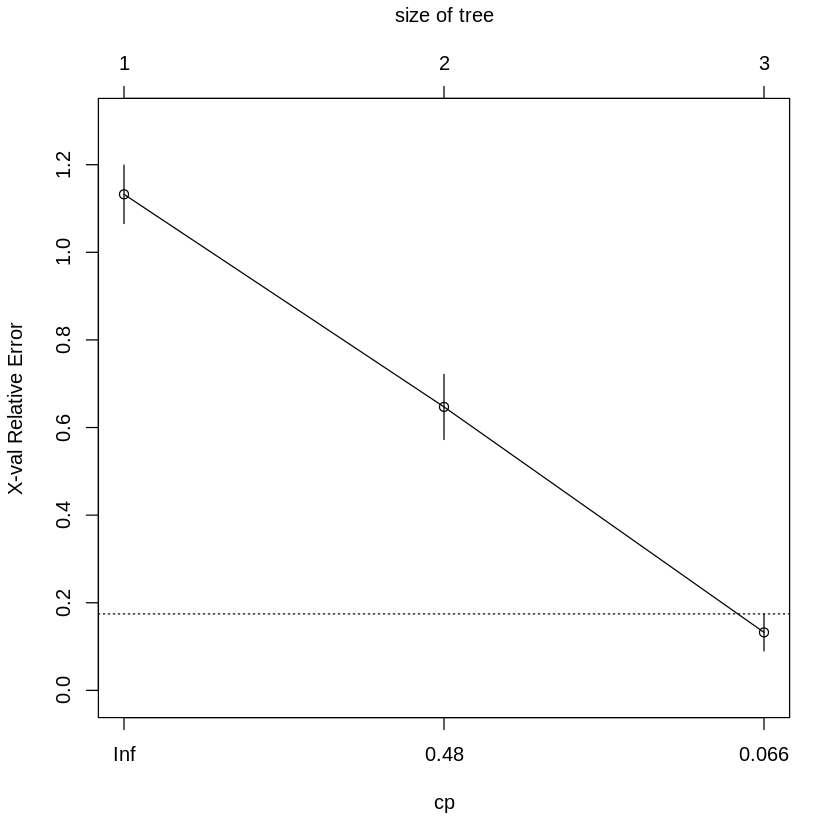

In [29]:
plotcp(tree_r)

1. 트리 크기에 따른 상대오차 막대로 표시 
2. 점선 : 최소 표준 오차 상한선

In [42]:
#opt<-which.min(tree_r$cptable[,"xerror"])
#cp2<-tree_r$cptable[opt,"CP"] ; cp2
cp<-min(tree_r$cptable[3,])  # cp객체 생성 (xerror 최소화)#
prune_tree_r<- prune(tree_r, cp=cp) #가지치기 
prune_tree_r 

n= 105 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 105 68 versicolor (0.3333333 0.3523810 0.3142857)  
  2) Petal.Length< 2.45 35  0 setosa (1.0000000 0.0000000 0.0000000) *
  3) Petal.Length>=2.45 70 33 versicolor (0.0000000 0.5285714 0.4714286)  
    6) Petal.Width< 1.65 40  3 versicolor (0.0000000 0.9250000 0.0750000) *
    7) Petal.Width>=1.65 30  0 virginica (0.0000000 0.0000000 1.0000000) *

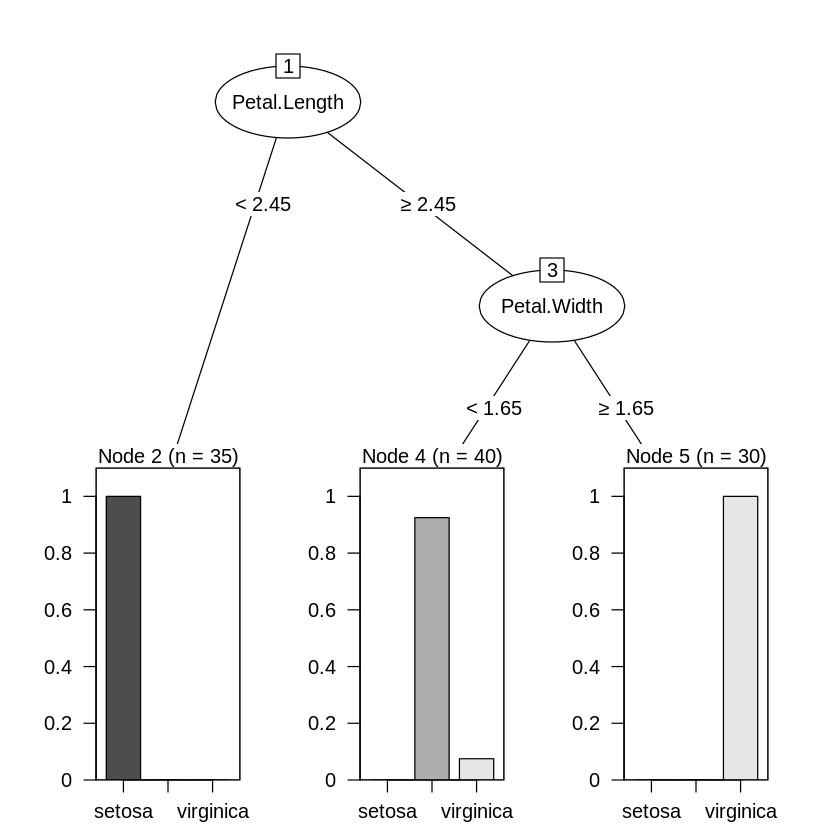

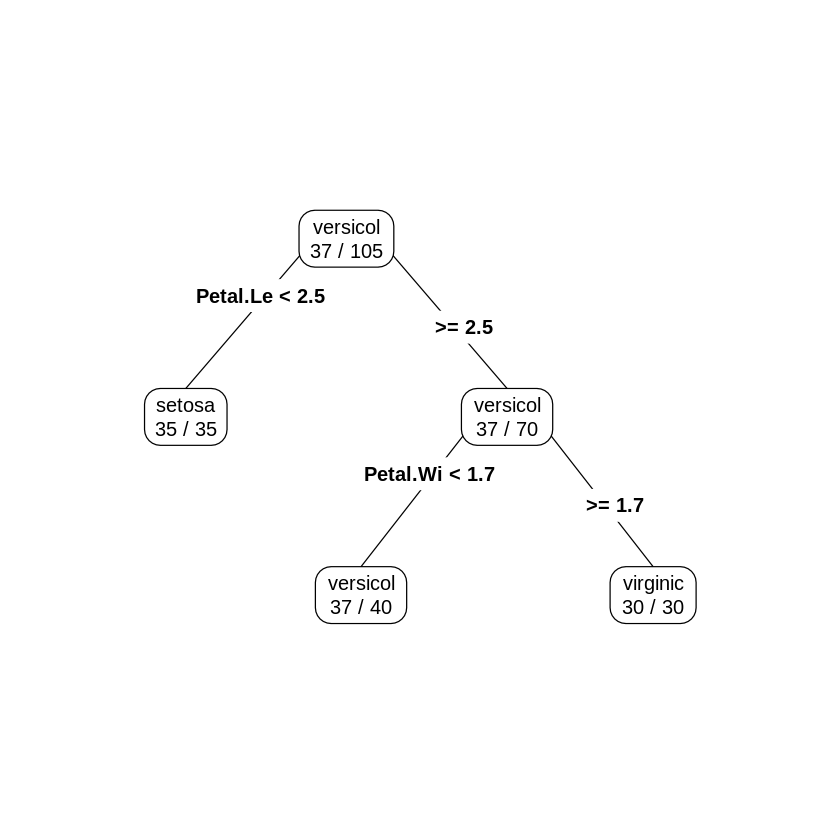

In [61]:
#par(mfrow=c(1,2))
plot(as.party(tree_r)) # 트리크기==분할횟수+1
#plot(as,party(prune_tree_r))
prp(tree_r,type=4,extra = 2) 

### STEP4. 최종모형 도출 및 성능 평가

In [23]:
pred_esvm<-predict(esvm, test) 
pred_ksvm<-predict(ksvm, test)
confusionMatrix(pred_esvm, test[,5], positive = "1") #  Accuracy : 0.9333  
confusionMatrix(pred_ksvm, test[,5], positive = "1") # Accuracy : 0.9778 

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa         15          0         0
  versicolor      0         10         0
  virginica       0          3        17

Overall Statistics
                                         
               Accuracy : 0.9333         
                 95% CI : (0.8173, 0.986)
    No Information Rate : 0.3778         
    P-Value [Acc > NIR] : 6.255e-15      
                                         
                  Kappa : 0.8985         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: setosa Class: versicolor Class: virginica
Sensitivity                 1.0000            0.7692           1.0000
Specificity                 1.0000            1.0000           0.8929
Pos Pred Value              1.0000            1.0000           0.8500
Neg Pred Value              1.0000            0.9143           1.0000
Prevalence

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa         15          0         0
  versicolor      0         12         0
  virginica       0          1        17

Overall Statistics
                                          
               Accuracy : 0.9778          
                 95% CI : (0.8823, 0.9994)
    No Information Rate : 0.3778          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9664          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: setosa Class: versicolor Class: virginica
Sensitivity                 1.0000            0.9231           1.0000
Specificity                 1.0000            1.0000           0.9643
Pos Pred Value              1.0000            1.0000           0.9444
Neg Pred Value              1.0000            0.9697           1.0000
P

In [63]:
pred_tree_r<-predict(tree_r, test, type="class")  # Accuracy : 0.9333
confusionMatrix(pred_tree_r, test[,5], positive = "1")

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa         15          0         0
  versicolor      0         11         1
  virginica       0          2        16

Overall Statistics
                                         
               Accuracy : 0.9333         
                 95% CI : (0.8173, 0.986)
    No Information Rate : 0.3778         
    P-Value [Acc > NIR] : 6.255e-15      
                                         
                  Kappa : 0.8991         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: setosa Class: versicolor Class: virginica
Sensitivity                 1.0000            0.8462           0.9412
Specificity                 1.0000            0.9688           0.9286
Pos Pred Value              1.0000            0.9167           0.8889
Neg Pred Value              1.0000            0.9394           0.9630
Prevalence

### STEP.5 결론
- 커널 파라미터 "rbfdot", 코스트 파라미터 C=0.1 인 SVM 모형의 accu 값이 0.9778 로 가장 우수항
- HMH기울기(gamma) 0.01, 코스트 10인 SVM모형과 분류트리의 Accu 값은 0.9333으로 같다.
- 사실상 별 차이 없음


In [24]:
#library(pROC)
#class(pred_esvm) ; #class(test[,5])
#roc_esvm<-roc(  as.numeric(pred_esvm), as.numeric(test[,5])    )
#?roc

In [25]:
#roc_esvm <- multiclass.roc( as.numeric(pred_esvm) , as.numeric(test[,5]) ) ; auc(roc_esvm) # 0.975
#roc_ksvm <- multiclass.roc( as.numeric(pred_ksvm) , as.numeric(test[,5]) ) ; auc(roc_ksvm) # 0.991